### Mount to Drive and Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/Shared drives/CIS522'

/content/drive/Shared drives/CIS522


In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install torch

In [ ]:
from transformers import DistilBertConfig, DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import TrainingArguments, Trainer

In [ ]:
import datasets
import pandas as pd
from datasets import load_dataset

import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [ ]:
import torch

### Model
We will be using an uncased pretrained Bert.

In [ ]:
model_path = 'distilbert-base-uncased'
config = DistilBertConfig.from_pretrained(model_path, num_labels=1)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = \
DistilBertForSequenceClassification.from_pretrained(model_path, config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifi

In [ ]:
stsb_train = pd.read_csv('bert_data.csv').drop('Unnamed: 0', axis=1).dropna()
stsb_train = stsb_train[:1431]
stsb_train = datasets.Dataset.from_dict(stsb_train)
stsb_validation = pd.read_csv('bert_data.csv').drop('Unnamed: 0', axis=1).dropna()
stsb_validation = stsb_validation[1431:]
stsb_val = datasets.Dataset.from_dict(stsb_validation[:250])
stsb_test = datasets.Dataset.from_dict(stsb_validation[250:])

In [ ]:
pd.DataFrame(stsb_train)

,idx,label,sentence1,sentence2
0,0,3.0,bootstrap styling rounded corners\n i do not ...,how to create a triangle in css3 using border-...
1,1,7.0,headless chrome is not redirecting\n we are u...,chromedriver opens sites only with valid ssl c...
2,2,3.0,linux syscalls and errno\n context: i am tryi...,virtual function table of multiple inheritance...
3,3,7.0,how to save user input with js and show info w...,how can i start a windows app background task ...
4,4,2.0,"function with a custom return type and the ""fa...",is inline assembly language slower than native...
...,...,...,...,...
1426,1441,3.0,use comparison signs inside a sql case stateme...,sql where in from param or variable\n context...
1427,1442,2.0,does unsigned math require more cpu instructio...,the localhost page is not working localhost is...
1428,1443,5.0,php - display a 404 error without redirecting ...,authorization not working in asp.net mvc 5\n ...
1429,1444,7.0,why is the angular 7 framework extremely slow ...,how can we develop coding practices designed t...


In [ ]:
stsb_train.shape, stsb_val.shape, stsb_test.shape

((1431, 4), (250, 4), (240, 4))

In [ ]:
enc_train = stsb_train.map(lambda e: tokenizer( e['sentence1'],e['sentence2'], padding=True, truncation=True), batched=True, batch_size=1000) 
enc_val =   stsb_val.map(lambda e: tokenizer( e['sentence1'],e['sentence2'], padding=True, truncation=True), batched=True, batch_size=1000) 
enc_test =  stsb_test.map(lambda e: tokenizer( e['sentence1'],e['sentence2'], padding=True, truncation=True), batched=True, batch_size=1000)

In [ ]:
pd.DataFrame(enc_train)

,idx,label,sentence1,sentence2,input_ids,attention_mask
0,0,3.0,bootstrap styling rounded corners\n i do not ...,how to create a triangle in css3 using border-...,"[101, 6879, 6494, 2361, 20724, 8352, 8413, 104...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,7.0,headless chrome is not redirecting\n we are u...,chromedriver opens sites only with valid ssl c...,"[101, 2132, 3238, 18546, 2003, 2025, 2417, 744...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2,3.0,linux syscalls and errno\n context: i am tryi...,virtual function table of multiple inheritance...,"[101, 11603, 25353, 15782, 12718, 1998, 9413, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,3,7.0,how to save user input with js and show info w...,how can i start a windows app background task ...,"[101, 2129, 2000, 3828, 5310, 7953, 2007, 1046...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,4,2.0,"function with a custom return type and the ""fa...",is inline assembly language slower than native...,"[101, 3853, 2007, 1037, 7661, 2709, 2828, 1998...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...
1426,1441,3.0,use comparison signs inside a sql case stateme...,sql where in from param or variable\n context...,"[101, 2224, 7831, 5751, 2503, 1037, 29296, 255...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1427,1442,2.0,does unsigned math require more cpu instructio...,the localhost page is not working localhost is...,"[101, 2515, 27121, 8785, 5478, 2062, 17368, 81...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1428,1443,5.0,php - display a 404 error without redirecting ...,authorization not working in asp.net mvc 5\n ...,"[101, 25718, 1011, 4653, 1037, 24837, 7561, 23...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1429,1444,7.0,why is the angular 7 framework extremely slow ...,how can we develop coding practices designed t...,"[101, 2339, 2003, 1996, 16108, 1021, 7705, 518...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


#### Training

In [ ]:
training_args = TrainingArguments(
    output_dir='./stsb-model', 
    do_train=True,
    do_eval=True,
    num_train_epochs=3,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',                
    logging_dir='./logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    save_strategy="steps",
    fp16=True,
    load_best_model_at_end=True
)

In [ ]:
def compute_metrics(pred):
    preds = np.squeeze(pred.predictions) 
    return {"MSE": ((preds - pred.label_ids) ** 2).mean().item(),
            "RMSE": (np.sqrt ((  (preds - pred.label_ids) ** 2).mean())).item(),
            "MAE": (np.abs(preds - pred.label_ids)).mean().item(),
     "Pearson" : pearsonr(preds,pred.label_ids)[0],
     "Spearman's Rank":spearmanr(preds,pred.label_ids)[0]
            }

In [ ]:
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=enc_train,
        eval_dataset=enc_val,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )

In [ ]:
train_result = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Mse,Rmse,Mae,Pearson,Spearman's rank
50,16.354100,4.349796,4.349796,2.085616,1.739789,-0.200735,-0.204659
100,3.703900,3.874276,3.874276,1.968318,1.805359,0.222450,0.223767


In [ ]:
q = [trainer.evaluate(eval_dataset=data) for data in [enc_train, enc_val, enc_test]]
pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

,eval_loss,eval_MSE,eval_RMSE,eval_MAE,eval_Pearson
train,3.266299,3.266299,1.807290,1.618563,0.335328
val,3.581978,3.581978,1.892611,1.715523,0.267777
test,2.871538,2.871538,1.694561,1.500798,0.342733


#### Inference

Inference: s1 is question 1 (title and body appended) and s2 is question 2. These are two dissimilar questions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
s1 = '''fluent interface for rendering html - 
rendering html with the htmltextwriter is not incredibly intuitive in my opinion, but if you are implementing web controls in web forms it is what you have to work with. i thought that it might be possible to create a fluent interface for this that reads a bit more like the html it outputs. i would like to know what people think of the syntax that i have come up with so far.      public void render(htmltextwriter writer)     {         writer             .tag(htmltextwritertag.div, e =&gt; e[htmltextwriterattribute.id, "id"][htmltextwriterattribute.name,"name"][htmltextwriterattribute.class,"class"])                 .tag(htmltextwritertag.span)                     .text("lorem")                 .endtag()                 .tag(htmltextwritertag.span)                     .text("ipsum")                 .endtag()             .endtag();             }   "tag", "text" and "endtag" are extension methods for the htmltextwriter class that returns the instance it takes in so that calls can be chained. the argument passed to the lambda used in the overload used by the first call to "tag" is a "htmlattributemanager", which is simple class that wraps an htmltextwriter to provide an indexer that takes an htmltextwriterattribute and a string value and returns the instance so that calls can be chained. i also have methods on this class for the most common attributes, such as "name", "class" and "id" so that you could write the first call above as follows:  .tag(htmltextwritertag.div, e =&gt; e.id("id").name("name").class("class"))   a little longer example:  public void render(htmltextwriter writer) {     writer         .tag(htmltextwritertag.div, a =&gt; a.class("someclass", "someotherclass"))             .tag(htmltextwritertag.h1).text("lorem").endtag()             .tag(htmltextwritertag.select, t =&gt; t.id("fooselect").name("fooselect").class("selectclass"))                 .tag(htmltextwritertag.option, t =&gt; t[htmltextwriterattribute.value, "1"][htmltextwriterattribute.title, "selects the number 1."])                     .text("1")                 .endtag(htmltextwritertag.option)                 .tag(htmltextwritertag.option, t =&gt; t[htmltextwriterattribute.value, "2"][htmltextwriterattribute.title, "selects the number 2."])                     .text("2")                 .endtag(htmltextwritertag.option)                 .tag(htmltextwritertag.option, t =&gt; t[htmltextwriterattribute.value, "3"][htmltextwriterattribute.title, "selects the number 3."])                     .text("3")                 .endtag(htmltextwritertag.option)             .endtag(htmltextwritertag.select)         .endtag(htmltextwritertag.div); }   hopefully you will be able to "decipher" what html this snippet outputs, at least that is the idea.  please give me any thoughts on how the syntax can be improved upon, maybe better method names, maybe some other approach all together.  edit: i thought it might be interesting to see what the same snippet would look like without the use of the fluent interface, for comparison:  public void renderusinghtmltextwriterstandardmethods(htmltextwriter writer) {     writer.addattribute(htmltextwriterattribute.class, "someclass someotherclass");     writer.renderbegintag(htmltextwritertag.div);      writer.renderbegintag(htmltextwritertag.h1);     writer.write("lorem");     writer.renderendtag();      writer.addattribute(htmltextwriterattribute.id, "fooselect");     writer.addattribute(htmltextwriterattribute.name, "fooselect");     writer.addattribute(htmltextwriterattribute.class, "selectclass");     writer.renderbegintag(htmltextwritertag.select);      writer.addattribute(htmltextwriterattribute.value, "1");     writer.addattribute(htmltextwriterattribute.title, "selects the number 1.");     writer.renderbegintag(htmltextwritertag.option);     writer.write("1");     writer.renderendtag();      writer.addattribute(htmltextwriterattribute.value, "2");     writer.addattribute(htmltextwriterattribute.title, "selects the number 2.");     writer.renderbegintag(htmltextwritertag.option);     writer.write("2");     writer.renderendtag();      writer.addattribute(htmltextwriterattribute.value, "3");     writer.addattribute(htmltextwriterattribute.title, "selects the number 3.");     writer.renderbegintag(htmltextwritertag.option);     writer.write("3");     writer.renderendtag();      writer.renderendtag();      writer.renderendtag(); }   edit: i should probably be a little more explicit in that one of the goals with this is that it should incur as little overhead as possible, this is why i have limited the use of lambdas. also at first i used a class that represented a tag so that something similar to a dom-tree was built by the syntax before the rendering, the syntax was very similar though. i abandoned this solution for the slight memory overhead it incurs. there are still some of this present in the use of the htmlattributemanager class, i have been thinking about using extension methods for the appending of attributes also, but the i cannot use the indexer-syntax, also it bloats the interface of the htmltextwriter even more. '''
s2 = '''why does the sqlserver optimizer get so confused with parameters? - 
i know this has something to do with parameter sniffing, but i am just perplexed at how something like the following example is even possible with a piece of technology that does so many complex things well.  many of us have run into stored procedures that intermittently run several of orders of magnitude slower than usual, and then if you copy out the sql from the procedure and use the same parameter values in a separate query window, it runs as fast as usual.  i just fixed a procedure like that by converting this:  alter procedure p_myproc (     @param1 int ) as -- do a complex query with @param1   to this:  alter procedure p_myproc (     @param1 int ) as  declare @param1copy int; set @param1copy = @param1;  -- do the query using @param1copy   it went from running in over a minute back down to under one second, like it usually runs.  this behavior seems totally random.  for 9 out of 10 @param1 inputs, the query is fast, regardless of how much data it ends up needing to crunch, or how big the result set it.  but for that 1 out of 10, it just gets lost.  and the fix is to replace an int with the same int in the query?  it makes no sense.  [edit]  @gbn linked to this question, which details a similar problem:    i hesitate to cry "bug!" because that is so often a cop-out, but this really does seem like a bug to me.  when i run the two versions of my stored procedure with the same input, i see identical query plans.  the only difference is that the original takes more than a minute to run, and the version with the goofy parameter copying runs instantly.'''
encoding = tokenizer(s1,s2, return_tensors='pt', padding=True, truncation=True, max_length=512)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
outputs = model(input_ids, attention_mask=attention_mask)
outputs.logits.item()

0.16618886590003967

The same inference as above except these two questions are similar. We see a much higher score.

In [ ]:
s1 = '''how do I concatenate two lists in Python? - 
how do I concatenate two lists in Python? Example: listone = [1, 2, 3] listtwo = [4, 5, 6] Expected outcome: >>> joinedlist [1, 2, 3, 4, 5, 6]'''
s2 = '''what is the fastest way to merge two lists in python? - 
Given, list_1 = [1,2,3,4] list_2 = [5,6,7,8] What is the fastest way to achieve the following in python? list = [1,2,3,4,5,6,7,8] Please note that there can be many ways to merge two lists in python. I am looking for the most time-efficient way.'''
encoding = tokenizer(s1,s2, return_tensors='pt', padding=True, truncation=True, max_length=512)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)
outputs = model(input_ids, attention_mask=attention_mask)
outputs.logits.item()

0.1999882161617279

### Calculating Top 5 Most Similar With this Model

In [1]:
import pandas as pd

In [4]:
data = pd.read_pickle('data_both_baselines.pkl')

In [10]:
def j(x): return ' '.join(map(str, x))

clean_title = data.apply(lambda x: j(x['clean tokenized title']), axis = 1)
data['Clean Title'] = clean_title

In [11]:
data['Concat Title Body'] = data['Clean Title'] + ' - ' + data['Clean Body']

First we pre-compute the encoding tokenization of every title + body

In [ ]:
input_ids = []
attention_mask = []
for i, s1 in enumerate(data['Concat Title Body']):
  print(i)
  encoding = tokenizer(s1, return_tensors='pt', padding=True, truncation=True, max_length=512)
  input_ids.append(encoding['input_ids'])
  attention_mask.append(encoding['attention_mask'])

In [ ]:
data['input_ids'] = input_ids
data['attention_mask'] = attention_mask

Now we can use these precomputed embeddings to run the comparisons and get the top 5 most similar

In [ ]:
def get_similarity(i, j):
  s2 = data['input_ids'][j]
  s2[0][0] = 102
  input_ids = torch.cat((data['input_ids'][i], s2), dim = 1)[:, 0:512]
  input_ids = input_ids.to(device)
  attention_mask = torch.cat((data['attention_mask'][i], data['attention_mask'][j]), dim = 1)[:, 0:512]
  attention_mask = attention_mask.to(device)
  outputs = model(input_ids, attention_mask=attention_mask)
  return outputs.logits.item()

In [ ]:
# Create a dictionary to store the top 5 sets for each set
top = {}
# Loop over each row, we will only be looking at the first 75 because of computation limitation
for i in np.arange(26, 76):
    top_five = set()
    for j, s2 in enumerate(data['Concat Title Body']):
        # Skip the same set
        if i == j:
            continue
        # Calculate similarity
        sim = get_similarity(i, j)
        if len(top_five) < 5:
          top_five.add((sim, j))
        elif any(sim > x for (id, x) in top_five):
          # swap lowest greater than for current
          top_five.remove(min(top_five))
          top_five.add((sim, j))
    t = [idx for (sim, idx) in top_five]
    print(i, ' : ', t)
    top[i] = t

In [ ]:
t = {0: [17, 15, 7, 16, 9],
 1: [5, 8, 7, 6, 9],
 2: [12, 16, 9, 15, 17],
 3: [15, 9, 11, 7, 16],
 4: [11, 12, 15, 16, 9],
 5: [9, 12, 15, 17, 16],
 6: [15, 16, 17, 9, 11],
 7: [15, 16, 9, 12, 11],
8  :  [12, 16, 10, 17, 15],
9  :  [12, 31, 36, 16, 35],
10  :  [50, 44, 24, 35, 22],
11  :  [16, 20, 35, 40, 39],
12  :  [32, 31, 21, 27, 24],
13  :  [65, 15, 35, 134, 135],
14  :  [1461, 4913, 6465, 321, 5677],
15  :  [1294, 1161, 418, 364, 442],
16  :  [12, 11, 15, 17, 7],
17  :  [1051, 1466, 1436, 1467, 1221],
18  :  [390, 1072, 1071, 142, 862],
19  :  [35, 24, 36, 12, 15],
20  :  [154, 115, 2685, 2686, 168],
21  :  [8, 49, 50, 58, 57],
22  :  [8, 6, 9, 16, 24],
23  :  [39, 51, 38, 25, 50],
24  :  [57, 35, 21, 42, 58],
25  :  [11, 12, 13, 9, 14],
26  :  [66, 35, 50, 65, 56],
27  :  [51, 24, 15, 50, 35],
28  :  [25, 12, 16, 24, 15],
29  :  [35, 24, 36, 15, 30],
30  :  [35, 42, 41, 15, 24],
31  :  [15, 41, 35, 42, 24],
32  :  [15, 24, 35, 50, 51],
33  :  [15, 31, 16, 24, 30],
34  :  [51, 50, 15, 35, 24],
35  :  [7, 6, 5, 8, 4],
36  :  [37, 16, 15, 24, 35],
37  :  [24, 41, 35, 42, 15],
38  :  [15, 24, 35, 49, 48],
39  :  [15, 31, 30, 32, 24],
40  :  [15, 38, 39, 35, 24],
41  :  [24, 7, 32, 31, 30],
42  :  [30, 31, 15, 24, 7],
43  :  [99, 50, 98, 65, 24],
44  :  [15, 24, 58, 57, 35],
45  :  [6, 5, 8, 7, 4],
46  :  [15, 9, 12, 17, 16],
47  :  [42, 24, 41, 35, 15],
48  :  [25, 15, 16, 24, 20],
49  :  [15, 16, 30, 31, 24],
50  :  [9, 20, 21, 14, 15],
51  :  [24, 48, 35, 49, 15],
52  :  [7, 15, 30, 31, 24],
53  :  [25, 15, 7, 24, 19],
54  :  [42, 24, 41, 35, 15],
55  :  [30, 31, 16, 15, 24],
56  :  [5, 8, 7, 4, 6],
57  :  [16, 7, 15, 12, 17],
58  :  [51, 50, 15, 35, 24],
59  :  [14, 17, 26, 16, 27],
60  :  [36, 15, 35, 24, 30],
61  :  [8, 5, 4, 7, 6],
62  :  [24, 15, 36, 35, 12],
63  :  [30, 24, 16, 7, 31],
64  :  [7, 6, 5, 8, 4],
65  :  [6, 8, 5, 4, 7],
66  :  [31, 7, 24, 16, 30],
67  :  [24, 22, 12, 35, 36],
68  :  [9, 15, 16, 7, 17],
69  :  [66, 24, 30, 65, 50],
70  :  [30, 39, 38, 35, 24],
71  :  [30, 36, 15, 35, 24],
72  :  [51, 35, 50, 24, 15],
73  :  [30, 31, 24, 15, 12],
74  :  [7, 4, 6, 5, 8],
75  :  [4, 7, 6, 8, 5]}

In [ ]:
t = pd.DataFrame.from_dict(top)  

In [ ]:
def get_id(lst):
  ids = [data[data.index == x]['Id'] for x in lst]
  return ids

In [ ]:
top_ids = dict((k, get_id(v)) for k, v in t.items())

In [ ]:
vals = list(top_ids.values())

In [ ]:
data['bert_top_five'] = None
data['bert_top_five'][0:76] = vals

In [ ]:
def flat(l):
    flat = [item for sublist in l for item in sublist]
    return flat

In [ ]:
data['bert_top_five'][0:76] = data['bert_top_five'][0:76].apply(lambda x: flat(x))

In [ ]:
data.to_pickle('data_all_top.pkl')

### Comparing baselines to model performance

In [ ]:
data = pd.read_pickle('data_all_top.pkl')

In [ ]:
# sample.to_pickle('data_complete_sample.pkl')

In [ ]:
def get_similarity_ids(id1, id2):
  i = int(data[data['Id'] == id1]['index'])
  j = int(data[data['Id'] == id2]['index'])
  s2 = data['input_ids'][j]
  input_ids = torch.cat((data['input_ids'][i], s2), dim = 1)[:, 0:512]
  input_ids = input_ids.to(device)
  attention_mask = torch.cat((data['attention_mask'][i], data['attention_mask'][j]), dim = 1)[:, 0:512]
  attention_mask = attention_mask.to(device)
  outputs = model(input_ids, attention_mask=attention_mask)
  return outputs.logits.item()

In [ ]:
avgs_baseline = []
avgs_dl_baseline = []
avgs_bert = []
for idx in range(0, 76):
  row = data.iloc[idx]
  scores_ndl = []
  scores_dl = []
  scores_b = []
  id1 = row['Id']
  for id2 in row['baseline_top_five']:
    scores_ndl.append(get_similarity_ids(id1, id2))
  avgs_baseline.append(sum(scores_ndl)/ 5)

  for idx2 in row['DL_baseline_top_five']:
    # DL baseline was saved as indexes not as IDS
    scores_dl.append(get_similarity(idx, idx2))
  avgs_dl_baseline.append(sum(scores_dl) / 5)

  for id2 in row['bert_top_five']:
    scores_b.append(get_similarity_ids(id1, id2))
  avgs_bert.append(sum(scores_b) / 5)

KeyboardInterrupt: ignored

In [ ]:
scores = pd.DataFrame({'Scores Baseline': avgs_baseline, 
                       'Scores DL Baseline': avgs_dl_baseline, 
                       'Scores Bert': avgs_bert})
scores

In [ ]:
# scores.to_pickle('scores.pkl')

In [ ]:
scores = pd.read_pickle('scores.pkl')

In [ ]:
import matplotlib as plt

In [ ]:
baseline_score = scores['Scores Baseline']

In [ ]:
dl_baseline = scores['Scores DL Baseline']

In [ ]:
bert_score = scores['Scores Bert']

In [ ]:
baseline_mean = baseline_score.mean()

In [ ]:
dl_mean = dl_baseline.mean()

In [ ]:
bert_mean = bert_score.mean()

In [ ]:
print(baseline_mean)

4.788020210517081


In [ ]:
print(dl_mean)

4.743390403295818


In [ ]:
print(bert_mean)

4.893443373629921


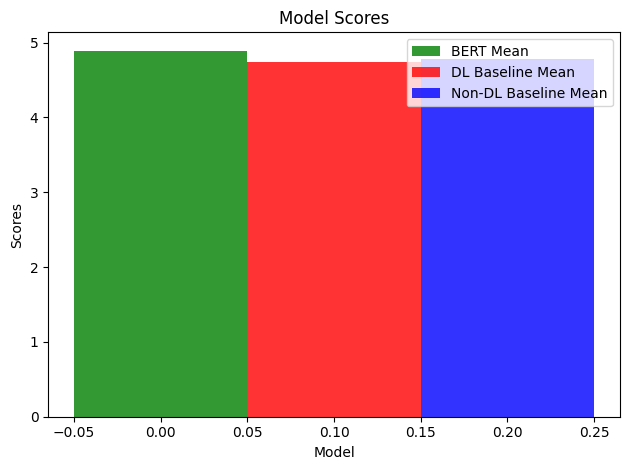

In [ ]:
import matplotlib.pyplot as plt
# data to plot
n_groups = 1

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

rects1 = plt.bar(index, bert_mean, bar_width,
alpha=opacity,
color='g',
label='BERT Mean')

rects2 = plt.bar(index + bar_width, dl_mean, bar_width,
alpha=opacity,
color='r',
label='DL Baseline Mean')

rects3 = plt.bar(index + 2*bar_width, baseline_mean, bar_width,
alpha=opacity,
color='b',
label='Non-DL Baseline Mean')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Scores')
# plt.xticks(index + bar_width)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
random_scores = scores.sample(n = 10)

In [ ]:
random_scores

,Scores Baseline,Scores DL Baseline,Scores Bert
64,4.369100,4.369100,4.369100
10,4.647186,4.685611,4.683213
5,4.874365,4.701156,5.116227
75,3.799045,3.799045,3.799045
62,5.039892,5.093361,5.115901
59,5.052292,5.066973,5.061177
37,4.979584,5.095797,5.100195
8,4.602028,4.109706,4.699764
21,4.857650,4.310897,4.734524
0,4.931478,4.891226,4.970648


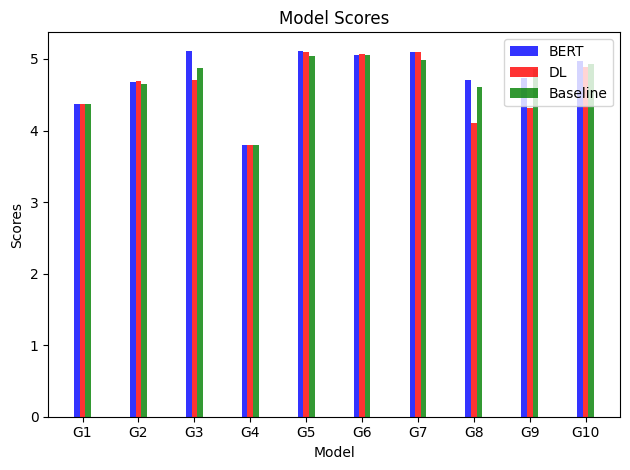

In [ ]:
# data to plot
n_groups = 10

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.8

baseline = random_scores['Scores Baseline']
dl = random_scores['Scores DL Baseline']
bert = random_scores['Scores Bert']

rects1 = plt.bar(index, bert, bar_width,
alpha=opacity,
color='b',
label='BERT')

rects2 = plt.bar(index + bar_width, dl, bar_width,
alpha=opacity,
color='r',
label='DL')

rects3 = plt.bar(index + 2*bar_width, baseline, bar_width,
alpha=opacity,
color='g',
label='Baseline')

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Scores')
plt.xticks(index + bar_width, ('G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
bert

64    4.369100
10    4.683213
5     5.116227
75    3.799045
62    5.115901
59    5.061177
37    5.100195
8     4.699764
21    4.734524
0     4.970648
Name: Scores Bert, dtype: float64

In [ ]:
top_scores = scores.sort_values(by='Scores Bert', ascending=False)

In [ ]:
top_scores.head(10)

,Scores Baseline,Scores DL Baseline,Scores Bert
4,4.604508,5.167230,5.130588
2,4.949911,4.835816,5.130262
19,5.147992,4.806785,5.123731
3,4.976227,4.856019,5.119223
5,4.874365,4.701156,5.116227
62,5.039892,5.093361,5.115901
36,5.071880,5.002657,5.107499
71,5.001514,4.935739,5.101020
37,4.979584,5.095797,5.100195
32,4.769992,5.048924,5.099828


In [ ]:
top_scores.drop(top_scores.index[[4,19]])

,Scores Baseline,Scores DL Baseline,Scores Bert
4,4.604508,5.167230,5.130588
2,4.949911,4.835816,5.130262
19,5.147992,4.806785,5.123731
3,4.976227,4.856019,5.119223
62,5.039892,5.093361,5.115901
...,...,...,...
1,4.206031,4.206031,4.206031
22,3.788540,3.674547,3.979750
61,3.882657,3.882657,3.882657
75,3.799045,3.799045,3.799045
